In [5]:
import sys
sys.path.append('..')
import logging
import torch
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import platform
import time
from models.AR_LSTM import AR_LSTM, train_epoch, validate, test
from utils.Analyser import Analyser
from utils.io import save_network, load_network, save, load
from utils.WaveDataset import create_datasets, transformVar, normalize
from utils.Scorekeeper import Scorekeeper

logging.basicConfig(format='%(message)s',level=logging.INFO)

# args, device = get_args()
experiment_name = 'ConvAE_LSTM_1ch_normalize_2'
num_workers = 1
num_channels = 1

device='cpu'

if 'Darwin' in platform.system():
    data_dir = '../'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("../Results"):
    os.mkdir("../Results")
results_dir = "../Results/" + experiment_name 

# Data
filename_data = os.path.join(results_dir,"all_data.pickle")
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = create_datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=num_channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)
    
train_dataset.root_dir = '../Video_Data/'
val_dataset.root_dir = '../Video_Data/'
test_dataset.root_dir = '../Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=num_workers)

Loading datasets


In [2]:
# test_dataset, val_dataset, train_dataset = create_datasets(
#      data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=num_channels)
# all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
# # save(all_data, filename_data)

In [8]:
# analyser
filename_analyser = os.path.join(results_dir,"analyser.pickle")
if os.path.isfile(filename_analyser):
    logging.info('Loading analyser')
    analyser = load(filename_analyser)
else:
    logging.info('Creating analyser')
    analyser = Analyser(results_dir)

# Model
filename_model = os.path.join(results_dir,"model.pt")
if os.path.isfile(filename_model):
    model = AR_LSTM(device, num_channels)
    model = load_network(model, device, filename_model)
else:
    model = AR_LSTM(device, num_channels)

# Learning Rate scheduler w. optimizer
# Optimizer
optimizer_algorithm = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# Add learning rate schedulers
# Decay LR by a factor of gamma every step_size epochs
scheduler_type = 'plateau'
if scheduler_type == 'step':
    gamma = 0.5
    step_size = 40
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer_algorithm, step_size=step_size, gamma=gamma)
elif scheduler_type == 'plateau':
    # Reduce learning rate when a metric has stopped improving
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_algorithm, mode='min', factor=0.1, patience=7)

    
filename_metadata = os.path.join(results_dir,"metadata.pickle" )
meta_data_dict = {  "optimizer": optimizer_algorithm.state_dict(),
                    "scheduler_type": scheduler_type, 
                    "scheduler": lr_scheduler.state_dict()}
save(meta_data_dict, filename_metadata)

model = model.to(device)
#

Creating analyser


TypeError: not all arguments converted during string formatting

In [9]:
test_dataset.transform = transformVar['Test']

Testing batch 1 out of 31
Testing batch 2 out of 31
Testing batch 3 out of 31
Testing batch 4 out of 31
Testing batch 5 out of 31
Testing batch 6 out of 31
Testing batch 7 out of 31
Testing batch 8 out of 31
Testing batch 9 out of 31
Testing batch 10 out of 31
Testing batch 11 out of 31
Testing batch 12 out of 31
Testing batch 13 out of 31
Testing batch 14 out of 31
Testing batch 15 out of 31
Testing batch 16 out of 31
Testing batch 17 out of 31
Testing batch 18 out of 31
Testing batch 19 out of 31
Testing batch 20 out of 31
Testing batch 21 out of 31
Testing batch 22 out of 31
Testing batch 23 out of 31
Testing batch 24 out of 31
Testing batch 25 out of 31
Testing batch 26 out of 31
Testing batch 27 out of 31
Testing batch 28 out of 31
Testing batch 29 out of 31
Testing batch 30 out of 31
Testing batch 31 out of 31


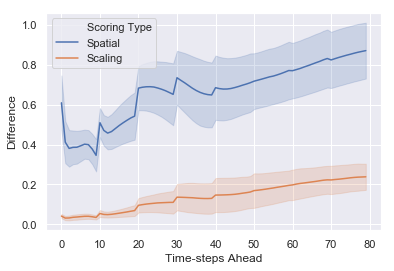

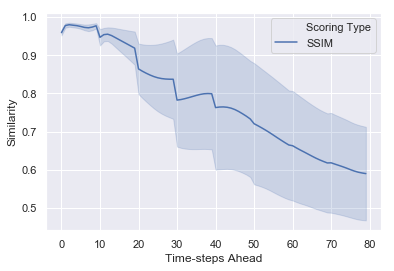

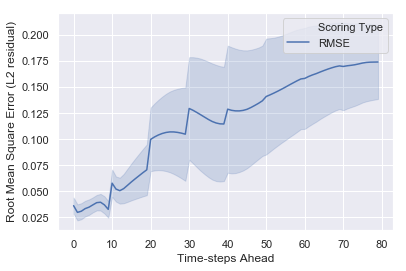

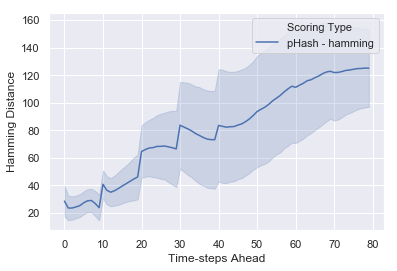

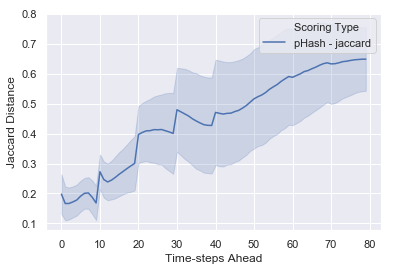

In [12]:
from utils.WaveDataset import normalize
# normalize={'std':1,'mean':0}
starting_point=15
num_input_frames = 5
reinsert_frequency = 10
channels=1
score_keeper = Scorekeeper(results_dir,channels,normalize)
figures_dir = os.path.join(results_dir, 'figures')
test(model, test_dataloader, starting_point, num_input_frames, reinsert_frequency, 
            channels, device, score_keeper, figures_dir, plot=False, debug=False)
score_keeper.plot()